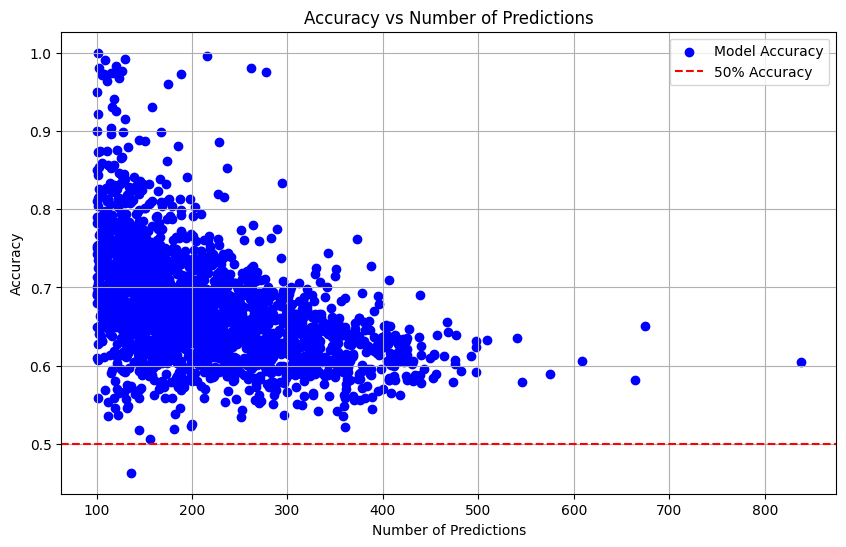

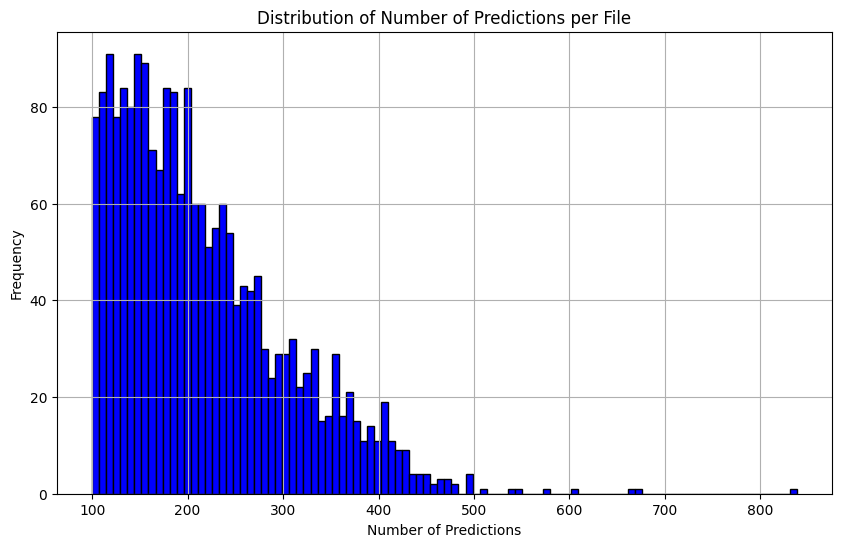

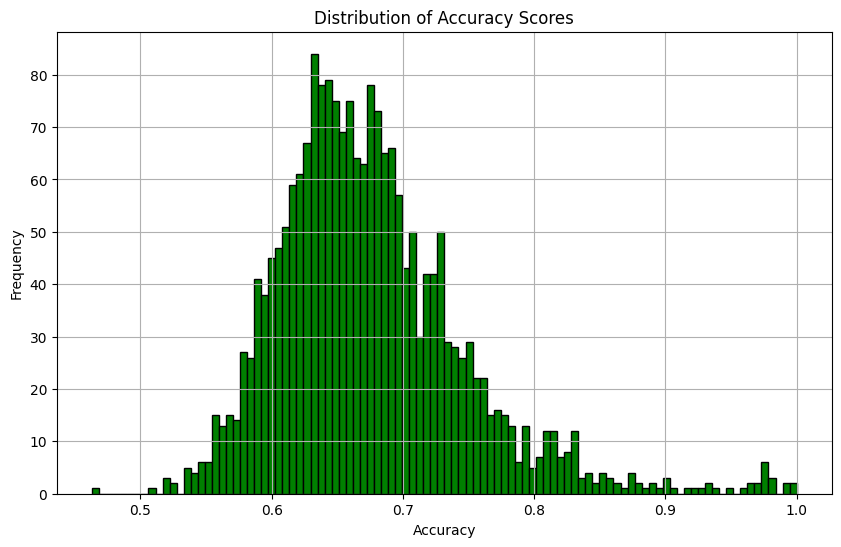

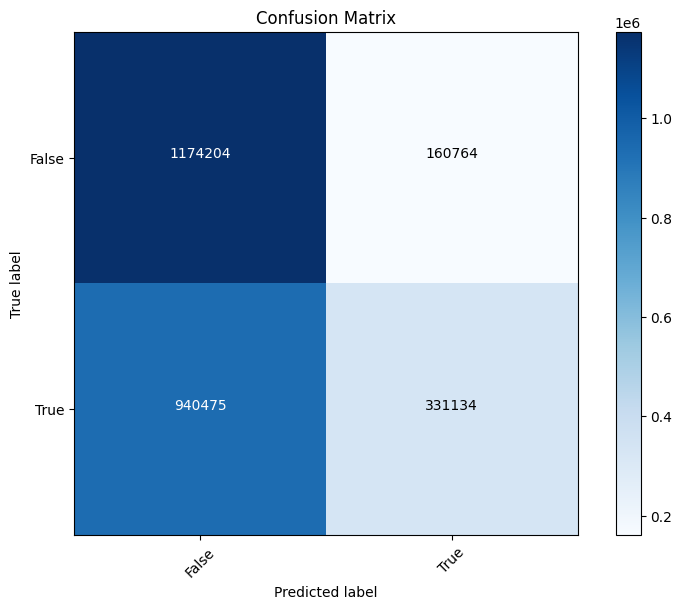

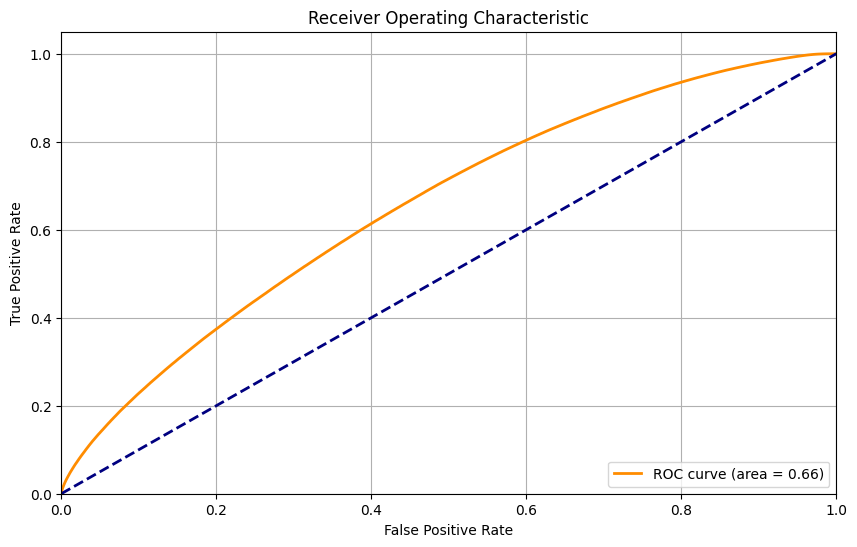

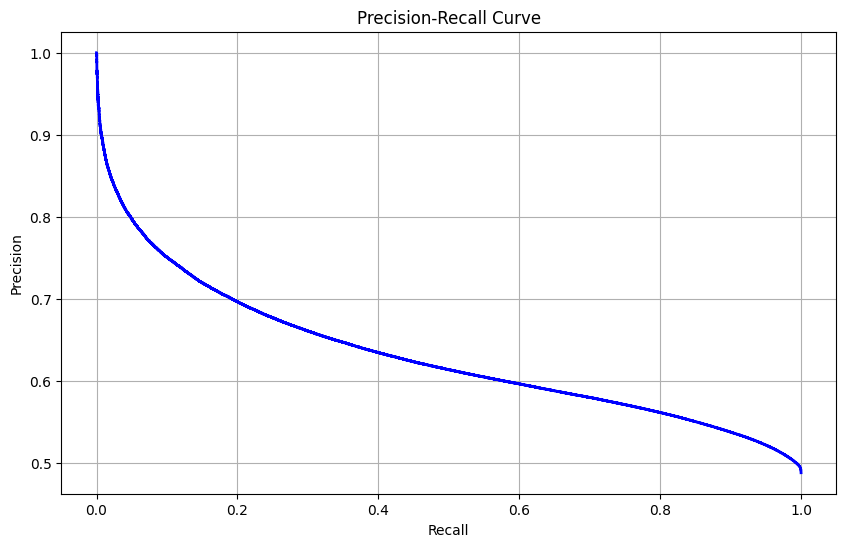


Validation Summary:
Total files processed: 2950
Total files with >= 100 predictions: 2085
Average Accuracy: 0.67
Files with insufficient predictions:
  - AACT-UN.parquet
  - AAMC.parquet
  - ABEV.parquet
  - ABR-PD.parquet
  - ABR-PE.parquet
  - ABR-PF.parquet
  - ACHR.parquet
  - ACP-PA.parquet
  - ACR-PD.parquet
  - ACR.parquet
  - ADC-PA.parquet
  - ADCT.parquet
  - ADRT.parquet
  - ADT.parquet
  - AEG.parquet
  - AESI.parquet
  - AFGD.parquet
  - AFGE.parquet
  - AG.parquet
  - AGI.parquet
  - AGM-A.parquet
  - AGM-PC.parquet
  - AGM-PG.parquet
  - AGRO.parquet
  - AGS.parquet
  - AHT-PG.parquet
  - AI.parquet
  - AIRI.parquet
  - AIV.parquet
  - AIZN.parquet
  - AKA.parquet
  - AKO-A.parquet
  - AKO-B.parquet
  - ALIT.parquet
  - ALL-PJ.parquet
  - ALLG.parquet
  - ALTG-PA.parquet
  - ALTM.parquet
  - ALUR.parquet
  - AMBI.parquet
  - AMBP.parquet
  - AMH-PG.parquet
  - AMH-PH.parquet
  - AMPS.parquet
  - AMPX.parquet
  - AMPY.parquet
  - AMS.parquet
  - ANG-PB.parquet
  - ANVS.p

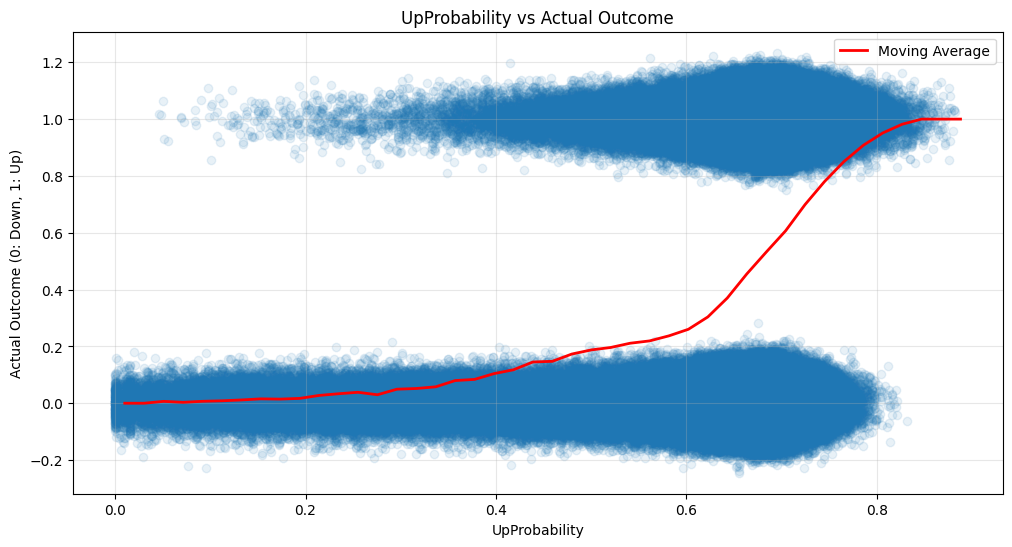

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools
##import the calibration_curve 
from sklearn.calibration import calibration_curve
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import binned_statistic



def validate_model_with_min_predictions(directory_path, min_predictions=10):
    summary_results = {
        "total_files": 0,
        "total_files_with_min_predictions": 0,
        "model_accuracies": [],
        "combined_accuracy": [],
        "files_with_few_predictions": [],
        "prediction_counts": [],
        "true_labels": [],
        "predicted_probs": [],
        "predicted_labels": []
    }

    files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)
        data = pd.read_parquet(file_path)

        ##ensure there are at least 90 days of data if it does not have 90 days of data skip
        if len(data) < 90:
            continue

        data['Date'] = pd.to_datetime(data['Date'])
        data['percentMove'] = data['Close'].pct_change()
        data['next_day_price_rise'] = data['percentMove'].shift(-1) > 0

        summary_results["total_files"] += 1

        prediction_col = 'UpPrediction'
        probability_col = 'UpProbability'

        selected_data = data[data[prediction_col] == 1].copy()
        TP = selected_data[selected_data['next_day_price_rise']].shape[0]
        total_predictions = selected_data.shape[0]

        if total_predictions >= min_predictions:
            accuracy = TP / total_predictions if total_predictions else 0
            summary_results['model_accuracies'].append(accuracy)
            summary_results['prediction_counts'].append(total_predictions)
            summary_results["total_files_with_min_predictions"] += 1
        else:
            summary_results['files_with_few_predictions'].append(file_name)

        summary_results['true_labels'].extend(data['next_day_price_rise'])
        summary_results['predicted_probs'].extend(data[probability_col])
        summary_results['predicted_labels'].extend(data[prediction_col])

    return summary_results

def plot_accuracy_vs_predictions(summary):
    plt.figure(figsize=(10, 6))
    x_values = summary['prediction_counts']
    y_values = summary['model_accuracies']
    
    if x_values and y_values:
        plt.scatter(x_values, y_values, color='blue', label="Model Accuracy")
    
    plt.title('Accuracy vs Number of Predictions')
    plt.axhline(y=0.5, color='r', linestyle='--', label='50% Accuracy')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_distribution_of_predictions(summary):
    plt.figure(figsize=(10, 6))
    plt.hist(summary['prediction_counts'], bins=100, color='blue', edgecolor='black')
    plt.title('Distribution of Number of Predictions per File')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(summary['model_accuracies'], bins=100, color='green', edgecolor='black')
    plt.title('Distribution of Accuracy Scores')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(summary):
    y_true = summary['true_labels']
    y_pred = summary['predicted_labels']
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
def plot_calibration_curve(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    plt.figure(figsize=(10, 6))
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()

def plot_cumulative_gains(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    percentages = np.arange(0, 110, 10)
    gains = []
    for percent in percentages:
        threshold = np.percentile(y_prob, 100 - percent)
        y_pred = (y_prob >= threshold).astype(int)
        gains.append(np.sum(y_true[y_pred == 1]) / np.sum(y_true) * 100)
    
    plt.figure(figsize=(10, 6))
    plt.plot(percentages, gains, marker='o')
    plt.plot([0, 100], [0, 100], linestyle='--')
    plt.xlabel('Percentage of Sample')
    plt.ylabel('Percentage of Positive Outcomes')
    plt.title('Cumulative Gains Curve')
    plt.grid(True)
    plt.show()

def simulate_trading(data, initial_balance=10000):
    balance = initial_balance
    positions = []
    for _, row in data.iterrows():
        if row['UpPrediction'] == 1 and balance > 0:
            position_size = balance * 0.02  # 2% of balance per trade
            shares = position_size / row['Close']
            balance -= position_size
            positions.append((shares, row['Close']))
        elif positions:
            for shares, buy_price in positions:
                balance += shares * row['Close']
            positions = []
    
    for shares, buy_price in positions:
        balance += shares * data.iloc[-1]['Close']
    
    return (balance - initial_balance) / initial_balance * 100

def plot_time_series_cv(summary, data):
    tscv = TimeSeriesSplit(n_splits=5)
    plt.figure(figsize=(12, 6))
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        y_true = test_data['next_day_price_rise']
        y_prob = test_data['UpProbability']
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Time Series Cross-Validation')
    plt.legend(loc="lower right")
    plt.show()

# Add these functions to your existing code
def enhanced_model_evaluation(summary, data):
    plot_calibration_curve(summary)
    plot_cumulative_gains(summary)
    plot_time_series_cv(summary, data)
    
    trading_performance = simulate_trading(data)
    print(f"Simulated Trading Performance: {trading_performance:.2f}%")



def plot_precision_recall_curve(summary):
    y_true = summary['true_labels']
    y_prob = summary['predicted_probs']
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', lw=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

def print_summary(summary):
    print("\nValidation Summary:")
    print(f"Total files processed: {summary['total_files']}")
    print(f"Total files with >= {min_predictions} predictions: {summary['total_files_with_min_predictions']}")
    
    if summary['model_accuracies']:
        print(f"Average Accuracy: {np.mean(summary['model_accuracies']):.2f}")
    print("Files with insufficient predictions:")
    for file in summary['files_with_few_predictions']:
        print(f"  - {file}")

def plot_up_probability_vs_outcome(summary):
    plt.figure(figsize=(12, 6))
    
    # Jitter the y-axis slightly for better visualization
    y_jittered = np.array(summary['true_labels']) + np.random.normal(0, 0.05, len(summary['true_labels']))
    
    plt.scatter(summary['predicted_probs'], y_jittered, alpha=0.1)
    plt.title('UpProbability vs Actual Outcome')
    plt.xlabel('UpProbability')
    plt.ylabel('Actual Outcome (0: Down, 1: Up)')
    plt.grid(True, alpha=0.3)
    
    # Add a loess smoothing curve
    bins = np.linspace(0, 1, 50)
    bin_means, bin_edges, _ = binned_statistic(summary['predicted_probs'], 
                                               summary['true_labels'], 
                                               statistic='mean', 
                                               bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, bin_means, 'r-', linewidth=2, label='Moving Average')
    
    plt.legend()
    plt.show()

# Example usage
directory_path = 'Data/RFpredictions'
min_predictions = 100
summary_results = validate_model_with_min_predictions(directory_path, min_predictions)
plot_accuracy_vs_predictions(summary_results)
plot_distribution_of_predictions(summary_results)
plot_confusion_matrix(summary_results)
plot_roc_curve(summary_results)
plot_precision_recall_curve(summary_results)
print_summary(summary_results)
plot_up_probability_vs_outcome(summary_results)


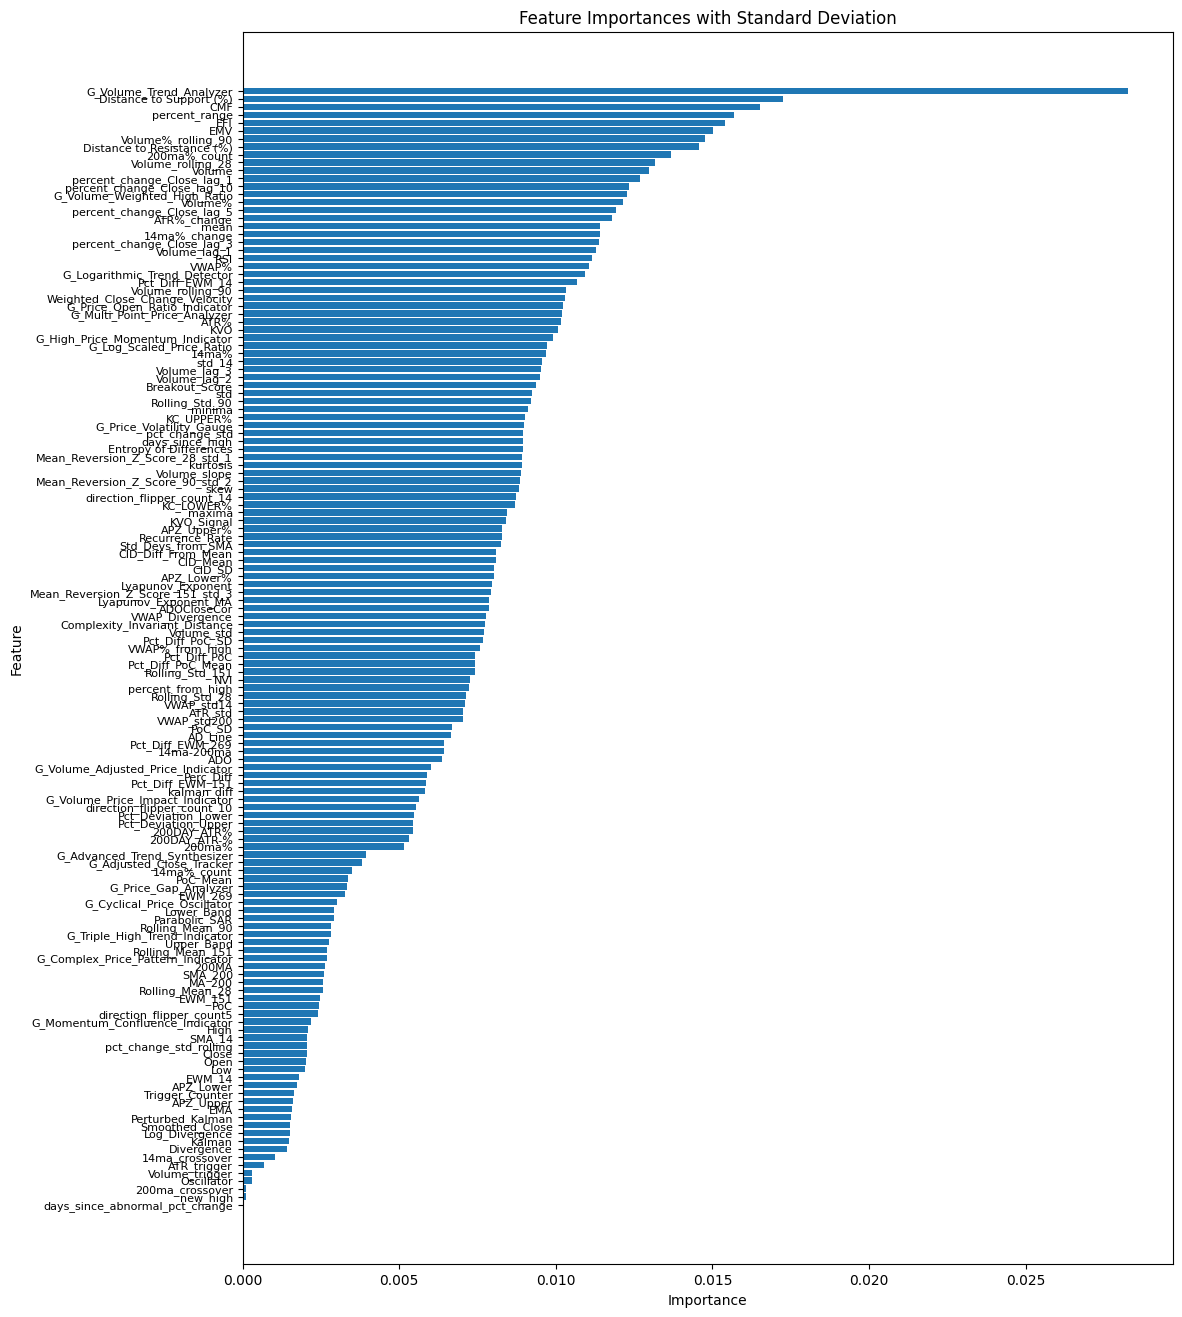

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the feature importance data
file_path = 'Data/ModelData/FeatureImportances/feature_importance.parquet'
feature_importance_df = pd.read_parquet(file_path)
##after loading the data sort it by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(12, 16))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')




plt.ylabel('Feature')

##space the labels out a bit more 
plt.yticks(fontsize=8)

plt.title('Feature Importances with Standard Deviation')
plt.gca().invert_yaxis()
plt.show()


In [4]:
import pandas as pd
from datetime import datetime




existing_df = pd.read_parquet("real_trade_data.parquet")


##remove the last row from the parquet file and save it 
existing_df = existing_df.iloc[:-1]
existing_df.to_parquet("real_trade_data.parquet")


In [10]:
import pandas as pd
import numpy as np
from termcolor import colored

def analyze_genetic_vs_traditional(file_path):
    # Load the feature importance data
    df = pd.read_parquet(file_path)
    
    # Sort by importance
    df = df.sort_values('importance', ascending=False)
    
    # Separate genetic and traditional indicators
    genetic_indicators = df[df['feature'].str.startswith('G_')]
    traditional_indicators = df[~df['feature'].str.startswith('G_')]
    
    # Calculate statistics
    genetic_count = len(genetic_indicators)
    traditional_count = len(traditional_indicators)
    genetic_in_top_20 = sum(genetic_indicators.index < 20)
    genetic_importance_sum = genetic_indicators['importance'].sum()
    traditional_importance_sum = traditional_indicators['importance'].sum()
    
    # Print analysis
    print(colored("\nAnalysis of Genetic vs Traditional Indicators", "cyan", attrs=['bold', 'underline']))
    print(colored("=" * 50, "cyan"))
    print(f"Total number of features: {len(df)}")
    print(f"Number of genetic indicators: {genetic_count}")
    print(f"Number of traditional indicators: {traditional_count}")
    print(f"\nGenetic indicators in top 20: {genetic_in_top_20}")
    print(f"Percentage of genetic indicators in top 20: {genetic_in_top_20/20*100:.2f}%")
    print(f"\nTotal importance of genetic indicators: {genetic_importance_sum:.4f}")
    print(f"Total importance of traditional indicators: {traditional_importance_sum:.4f}")
    print(f"Average importance of genetic indicators: {genetic_importance_sum/genetic_count:.4f}")
    print(f"Average importance of traditional indicators: {traditional_importance_sum/traditional_count:.4f}")
    
    # List top 5 genetic indicators
    print(colored("\nTop 5 Genetic Indicators:", "green", attrs=['bold']))
    for i, (_, row) in enumerate(genetic_indicators.head().iterrows(), 1):
        print(f"{i}. {row['feature']} (Importance: {row['importance']:.4f})")
    
    # Compare to highest traditional indicator
    top_traditional = traditional_indicators.iloc[0]
    print(colored(f"\nHighest Traditional Indicator:", "yellow", attrs=['bold']))
    print(f"{top_traditional['feature']} (Importance: {top_traditional['importance']:.4f})")
    
    # Conclusion
    print(colored("\nConclusion:", "magenta", attrs=['bold']))
    if genetic_importance_sum/genetic_count > traditional_importance_sum/traditional_count:
        print("On average, genetic indicators appear to be more important than traditional indicators.")
    else:
        print("On average, traditional indicators appear to be more important than genetic indicators.")
    print(f"The top genetic indicator {'is' if genetic_indicators.iloc[0]['importance'] > top_traditional['importance'] else 'is not'} more important than the top traditional indicator.")

# Usage
file_path = 'Data/ModelData/FeatureImportances/feature_importance.parquet'
analyze_genetic_vs_traditional(file_path)


Analysis of Genetic vs Traditional Indicators
Total number of features: 141
Number of genetic indicators: 17
Number of traditional indicators: 124

Genetic indicators in top 20: 2
Percentage of genetic indicators in top 20: 10.00%

Total importance of genetic indicators: 0.1339
Total importance of traditional indicators: 0.8661
Average importance of genetic indicators: 0.0079
Average importance of traditional indicators: 0.0070

Top 5 Genetic Indicators:
1. G_Volume_Trend_Analyzer (Importance: 0.0283)
2. G_Volume_Weighted_High_Ratio (Importance: 0.0123)
3. G_Logarithmic_Trend_Detector (Importance: 0.0109)
4. G_Price_Open_Ratio_Indicator (Importance: 0.0102)
5. G_Multi_Point_Price_Analyzer (Importance: 0.0102)

Highest Traditional Indicator:
Distance to Support (%) (Importance: 0.0173)

Conclusion:
On average, genetic indicators appear to be more important than traditional indicators.
The top genetic indicator is more important than the top traditional indicator.


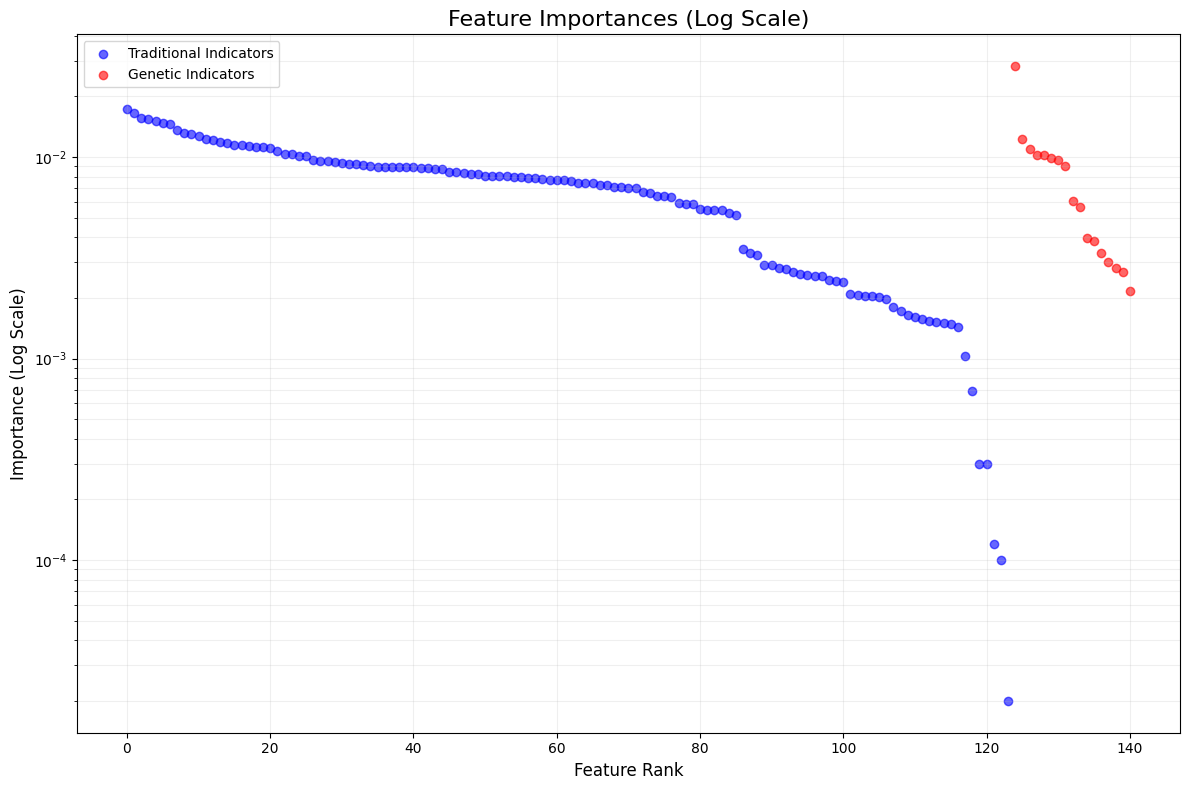

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances_log(file_path):
    # Load the feature importance data
    df = pd.read_parquet(file_path)
    
    # Sort by importance
    df = df.sort_values('importance', ascending=False)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Separate genetic and traditional indicators
    genetic_indicators = df[df['feature'].str.startswith('G_')]
    traditional_indicators = df[~df['feature'].str.startswith('G_')]
    
    # Plot points
    plt.scatter(range(len(traditional_indicators)), traditional_indicators['importance'], 
                color='blue', alpha=0.6, label='Traditional Indicators')
    plt.scatter(range(len(df)-len(genetic_indicators), len(df)), genetic_indicators['importance'], 
                color='red', alpha=0.6, label='Genetic Indicators')
    
    # Set y-axis to log scale
    plt.yscale('log')
    
    # Customize the plot
    plt.title('Feature Importances (Log Scale)', fontsize=16)
    plt.xlabel('Feature Rank', fontsize=12)
    plt.ylabel('Importance (Log Scale)', fontsize=12)
    
    # Add a legend
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage
file_path = 'Data/ModelData/FeatureImportances/feature_importance.parquet'
plot_feature_importances_log(file_path)